# Exploring Financial Data Using Nasdaq Data Link API

In this data science project, I used Python and the Nasdaq Data Link API to analyze economic data. I cleaned financial datasets with pandas, analyzed stock trends, created visualizations with Matplotlib, and developed a linear regression model using time and expense turnover to predict a financial metric. This enhanced my skills in financial data analysis.

In [69]:
# Import libraries
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [51]:
# Configure api key
api_key = 'CEdUwCyzPD5wV8-KXy2y'

# Json file source
api_url = 'https://data.nasdaq.com/api/v3/datatables/MER/F1.json'

parameters = {
    'api_key': api_key,
    'qopts.per_page': 10
}

# Fetch data and convert to json using HTTP get request
json_data = requests.get(api_url, params = parameters).json()

# Get an initial view of json file
print(json_data)

{'datatable': {'data': [[2438, 1868192544, -1802, 10.481948, '2011-06-30', 'Q2', 'U', 'EUR', 'True', 'Deutsche Bank AG', 'Deutsche Bank AG', 'Active', 'DEU', 'Europe', 1159508, '5.1.1', 'DB', 'NYS', 'Taunusanlage 12', None, None, None, 'Frankfurt am Main', None, 'DEU', '60325', '(49) 69 910 00', '(49) 69 910 34 225', 'www.db.com', '2023-12-31', 'Accrued Expenses Turnover', 'Derived'], [2438, 1868216112, -1802, 8.161754, '2011-09-30', 'Q3', 'U', 'EUR', 'True', 'Deutsche Bank AG', 'Deutsche Bank AG', 'Active', 'DEU', 'Europe', 1159508, '5.1.1', 'DB', 'NYS', 'Taunusanlage 12', None, None, None, 'Frankfurt am Main', None, 'DEU', '60325', '(49) 69 910 00', '(49) 69 910 34 225', 'www.db.com', '2023-12-31', 'Accrued Expenses Turnover', 'Derived'], [2438, 1885063456, -1802, 10.788213, '2012-06-30', 'Q2', 'U', 'EUR', 'True', 'Deutsche Bank AG', 'Deutsche Bank AG', 'Active', 'DEU', 'Europe', 1159508, '5.1.1', 'DB', 'NYS', 'Taunusanlage 12', None, None, None, 'Frankfurt am Main', None, 'DEU', '60

# Processing and Cleaning the JSON File Into a DataFrame

In [53]:
api_url = 'https://data.nasdaq.com/api/v3/datatables/MER/F1.json'

# Define the parameters for the API request, including the API key and the number of results per page
parameters = {
    'api_key': api_key,
    'qopts.per_page': 10000
}

# Make a GET request to the API URL with the specified parameters and store the response in json_data
json_data = requests.get(api_url, params = parameters).json()

# Extract the data part of the response, which contains the actual dataset
data = json_data['datatable']['data']
columns = []

# Loop through the columns part of the response to extract the names of the columns
for col in json_data['datatable']['columns']:
    columns.append(col['name'])

# Create a DataFrame from the data using the extracted column names and display the first few rows (data cleaning part)
df_metric = pd.DataFrame(data, columns = columns)
df_metric.head()

,compnumber,reportid,mapcode,amount,reportdate,reporttype,auditorstatus,currency,consolidated,longname,...,city,statecode,country,zipcode,phonenumber,faxnumber,website,fye,indicator,statement
0,2438,1868192544,-1802,10.481948,2011-06-30,Q2,U,EUR,True,Deutsche Bank AG,...,Frankfurt am Main,None,DEU,60325,(49) 69 910 00,(49) 69 910 34 225,www.db.com,2023-12-31,Accrued Expenses Turnover,Derived
1,2438,1868216112,-1802,8.161754,2011-09-30,Q3,U,EUR,True,Deutsche Bank AG,...,Frankfurt am Main,None,DEU,60325,(49) 69 910 00,(49) 69 910 34 225,www.db.com,2023-12-31,Accrued Expenses Turnover,Derived
2,2438,1885063456,-1802,10.788213,2012-06-30,Q2,U,EUR,True,Deutsche Bank AG,...,Frankfurt am Main,None,DEU,60325,(49) 69 910 00,(49) 69 910 34 225,www.db.com,2023-12-31,Accrued Expenses Turnover,Derived
3,2438,1885087024,-1802,9.437545,2012-09-30,Q3,U,EUR,True,Deutsche Bank AG,...,Frankfurt am Main,None,DEU,60325,(49) 69 910 00,(49) 69 910 34 225,www.db.com,2023-12-31,Accrued Expenses Turnover,Derived
4,2438,1901934112,-1802,8.755041,2013-06-30,Q2,U,EUR,True,Deutsche Bank AG,...,Frankfurt am Main,None,DEU,60325,(49) 69 910 00,(49) 69 910 34 225,www.db.com,2023-12-31,Accrued Expenses Turnover,Derived


# Filtering the DataFrame for Relevant Information

In [55]:
# Only display columns with information relevant to our analysis
relevant_columns = ['reportid', 'reportdate', 'reporttype', 'amount', 'longname', 'country', 'region', 'indicator', 'statement']

In [57]:
# Filter DataFrame so that only relevant columns remain
df_metric = df_metric[relevant_columns]

# Only want columns that starts with indicator of 'Accrued Expenses Turnover'
filtered_df = df_metric[df_metric['indicator'] == 'Accrued Expenses Turnover']
filtered_df['indicator'].describe()

count                           139
unique                            1
top       Accrued Expenses Turnover
freq                            139
Name: indicator, dtype: object

# Reorganizing DataFrame

In [59]:
# Create a function that updates country name based on code
def update_country_name(name):
    if name == 'USA':
        name = 'United States of America'
    elif name == 'JPN':
        name = 'Japan'
    elif name == 'CYM':
        name = 'Cayman Islands'
    elif name == 'BHS':
        name = 'Bahamas'
    elif name == 'DEU':
        name = 'Germany'
    else:
        name = 'Ireland'
    
    return name

# create a temporary copy of filtered_df
filtered_df = filtered_df.copy()

# Apply the update_country_name function to the 'country' column and create a new column 'country_name'
filtered_df['country_name'] = filtered_df['country'].apply(update_country_name)

# Add underscores for clarity
filtered_df.columns = [
    'report_id', 'report_date', 'report_type', 'amount', 
    'company_name', 'country', 'region', 'indicator', 'statement', 'country_name'
]

# Create new DataFrame with all of the counts of each unique value each country_name appears
updated_df = filtered_df.copy()
updated_df['country_name'].value_counts()

country_name
United States of America    31
Ireland                     29
Japan                       27
Cayman Islands              27
Bahamas                     19
Germany                      6
Name: count, dtype: int64

# Plotting Data to See Financial Trends

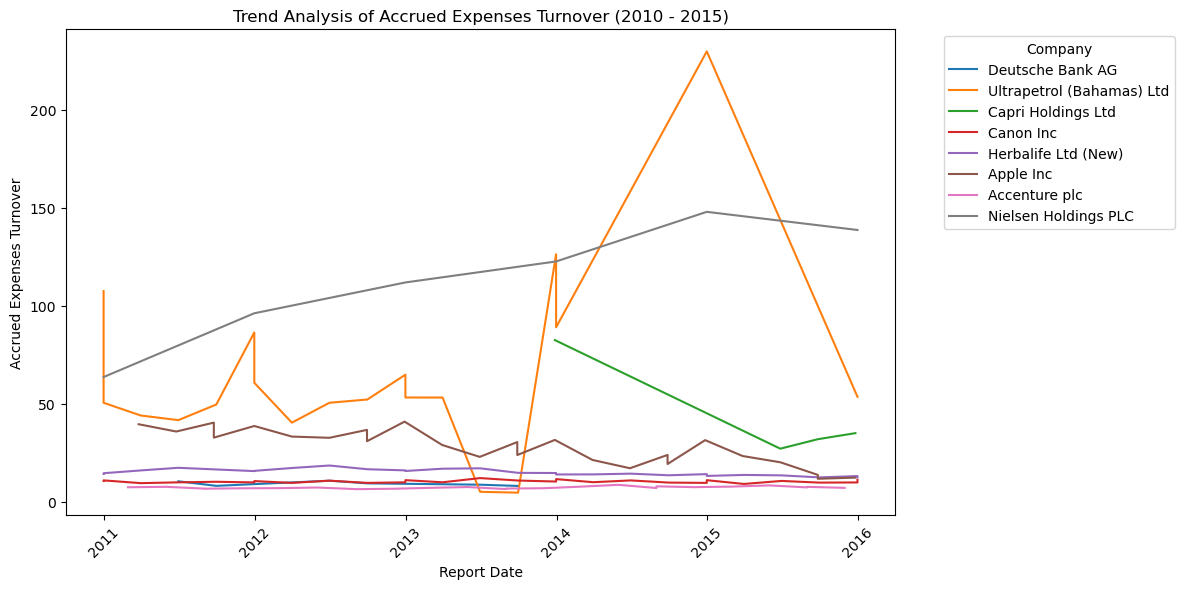

In [61]:


# Filtering out all data not within 2010 to 2015
updated_df['report_date'] = pd.to_datetime(updated_df['report_date'])
updated_df = updated_df[(updated_df['report_date'].dt.year >= 2010) & (updated_df['report_date'].dt.year <= 2015)]

# Create new DataFrame with columns relevant to plotting
relevant_data = updated_df[['company_name', 'report_date', 'amount']].copy()

# Plotting the trends
plt.figure(figsize = (12, 6))

for company in relevant_data['company_name'].unique():
    company_data = relevant_data[relevant_data['company_name'] == company]
    plt.plot(company_data['report_date'], company_data['amount'], label = company)

# Adding additional details
plt.title('Trend Analysis of Accrued Expenses Turnover (2010 - 2015)')
plt.xlabel('Report Date')
plt.ylabel('Accrued Expenses Turnover')
plt.xticks(rotation = 45)
plt.legend(title = 'Company', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

# Geographical Region Analysis

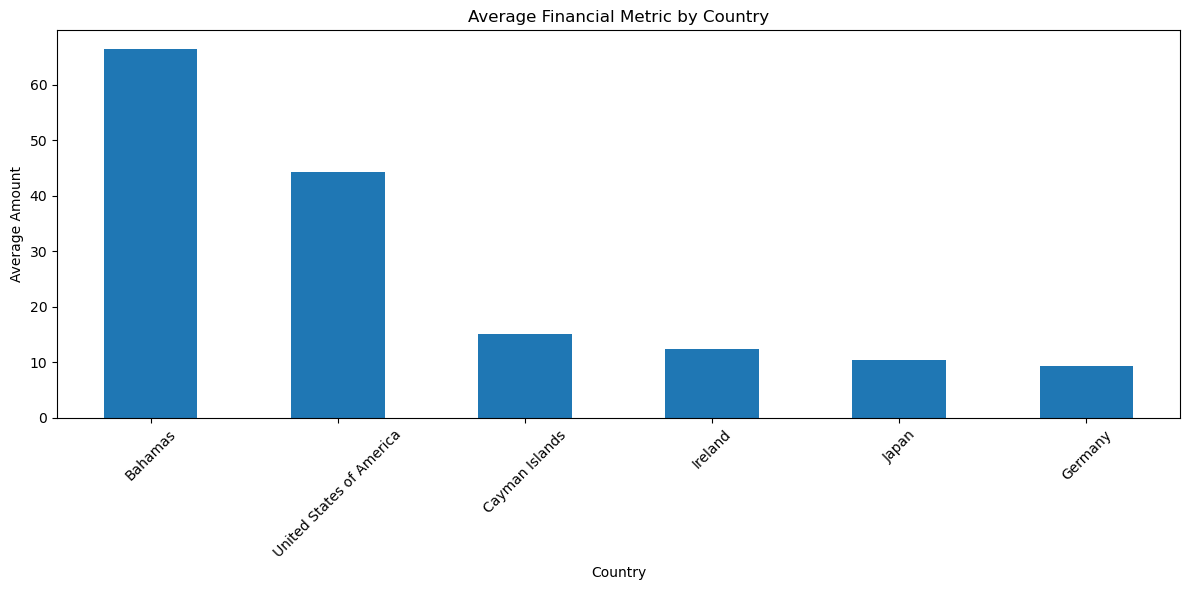

In [63]:
# Plotting for geographical region analysis
country_avg = updated_df.groupby('country_name')['amount'].mean()
plt.figure(figsize = (12, 6))
country_avg.sort_values(ascending = False).plot(kind = 'bar')
plt.title('Average Financial Metric by Country')
plt.xlabel('Country')
plt.ylabel('Average Amount')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()                                                  

# Set Up DataFrames for Linear Regression Model

In [73]:
# Set up JSON and DataFrames again for covenience
parameters = {
    'api_key': api_key,
    'qopts.per_page': 10000  
}

api_url = 'https://data.nasdaq.com/api/v3/datatables/MER/F1.json'
json_data = requests.get(api_url, params = parameters).json()
data = json_data['datatable']['data']

columns = []
for col in json_data['datatable']['columns']:
    columns.append(col['name'])
df = pd.DataFrame(data, columns = columns)

print(df.head())
print(df.info())

   compnumber    reportid  mapcode     amount  reportdate reporttype  \
0        2438  1868192544    -1802  10.481948  2011-06-30         Q2   
1        2438  1868216112    -1802   8.161754  2011-09-30         Q3   
2        2438  1885063456    -1802  10.788213  2012-06-30         Q2   
3        2438  1885087024    -1802   9.437545  2012-09-30         Q3   
4        2438  1901934112    -1802   8.755041  2013-06-30         Q2   

  auditorstatus currency consolidated          longname  ...  \
0             U      EUR         True  Deutsche Bank AG  ...   
1             U      EUR         True  Deutsche Bank AG  ...   
2             U      EUR         True  Deutsche Bank AG  ...   
3             U      EUR         True  Deutsche Bank AG  ...   
4             U      EUR         True  Deutsche Bank AG  ...   

                city statecode country zipcode     phonenumber  \
0  Frankfurt am Main      None     DEU   60325  (49) 69 910 00   
1  Frankfurt am Main      None     DEU   60325  (4

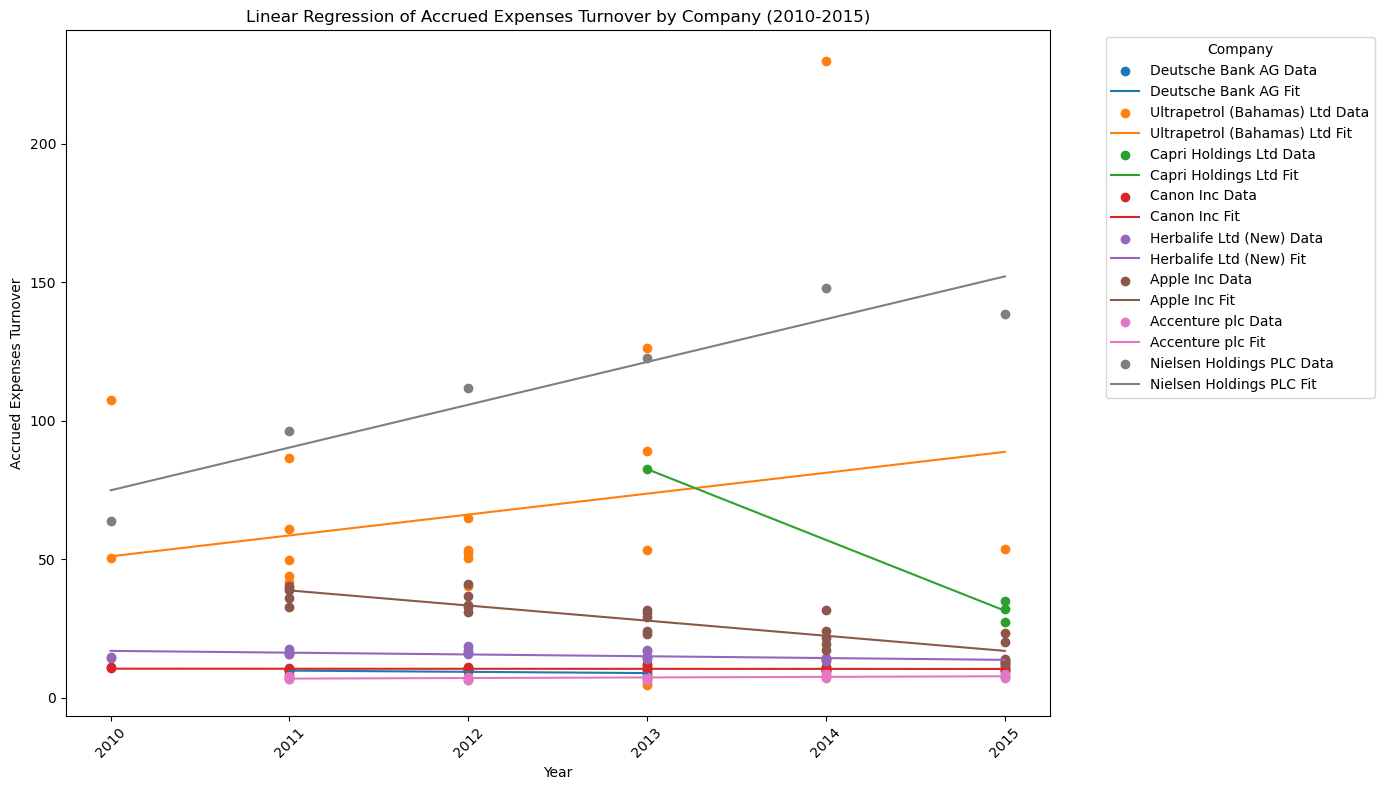

In [76]:
updated_df['year'] = updated_df['report_date'].dt.year
regression_data = updated_df[['company_name', 'year', 'amount']].copy()

# Initialize model
model = LinearRegression()
plt.figure(figsize=(14, 8))

# Plot data for each company
for company in regression_data['company_name'].unique():
    company_data = regression_data[regression_data['company_name'] == company]
    
    X = company_data[['year']].values.reshape(-1, 1)  # Independent variable
    y = company_data['amount'].values  # Dependent variable
    
    model.fit(X, y)
    
    predictions = model.predict(X)

    # Plot the best fit line 
    plt.scatter(company_data['year'], company_data['amount'], label=f'{company} Data')
    plt.plot(company_data['year'], predictions, label=f'{company} Fit')

plt.title('Linear Regression of Accrued Expenses Turnover by Company (2010-2015)')
plt.xlabel('Year')
plt.ylabel('Accrued Expenses Turnover')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()